# Topic Modelling

In [22]:
import os
import re
import pickle

from pprint import pprint
import numpy as np
import pandas as pd
from konlpy.tag import Komoran
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook(local=True)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from src.env import PROJECT_DIR

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [3]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

형태소 분석기 확인

In [5]:
komo = Komoran()

In [6]:
komo.morphs('이는 경기도가 부동산 안정화의 해법으로 수차례 강조한 ‘경기도 기본주택 공급’과 ‘기본소득토지세 신설’ 등 부동산 정책들이 신뢰를 갖도록 하는 사전 포석으로 풀이된다.')

['이',
 '는',
 '경기도',
 '가',
 '부동산',
 '안정',
 '화',
 '의',
 '해법',
 '으로',
 '수차례',
 '강조',
 '하',
 'ㄴ',
 '‘',
 '경기도',
 '기본',
 '주택',
 '공급',
 '’',
 '과',
 '‘',
 '기본소득',
 '토지세',
 '신설',
 '’',
 '등',
 '부동산',
 '정책',
 '들',
 '이',
 '신뢰',
 '를',
 '갖',
 '도록',
 '하',
 '는',
 '사전',
 '포석',
 '으로',
 '풀이',
 '되',
 'ㄴ다',
 '.']

In [7]:
for k, v in dfs.items():
    dfs[k].drop(['nouns'], axis=1, inplace=True)
    dfs[k].loc[:, 'morphs'] = v.text.apply(komo.morphs)

In [10]:
with open(PROJECT_DIR / 'data' / 'processed' / 'all_articles_1-morphs.pkl', 'wb') as fp:
    pickle.dump(dfs, fp)

Get TF-IDF representation vectors

In [ ]:
with open(PROJECT_DIR / 'data' / 'processed' / 'all_articles_1-morphs.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

Compare BC vs. AD

In [11]:
split_date = pd.Timestamp(2020, 2, 25)

In [12]:
print(split_date)

2020-02-25 00:00:00


In [15]:
all_docs_tokenized_before = []
all_docs_tokenized_after = []

for k, v in dfs.items():
    all_docs_tokenized_before.extend(v.morphs[v.index < split_date].tolist())
    all_docs_tokenized_after.extend(v.morphs[v.index >= split_date].tolist())

In [17]:
all_docs_tokenized = all_docs_tokenized_before + all_docs_tokenized_after

Set max_features=2000 since we have < 2100 documents

In [18]:
max_features = 2000
max_df = 0.4
min_df = 10

save_path = PROJECT_DIR / "models" / f"tfidf-max_features-{max_features}-max_df-{max_df}-min_df-{min_df}.pkl"
if os.path.exists(save_path):
    with open(save_path, "rb") as fp:
        tfidf_vectorizer = pickle.load(fp)
    dtm_tfidf = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized])
else:
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features)

    dtm_tfidf = tfidf_vectorizer.fit_transform([' '.join(x) for x in all_docs_tokenized])

    with open(save_path, "wb") as fp:
        pickle.dump(tfidf_vectorizer, fp)

In [19]:
dtm_tfidf_before = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_before])
dtm_tfidf_after = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_after])

# LDA

In [23]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [24]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.056026 -0.028366       1        1  68.016469
10    -0.219241  0.057811       2        1  21.411555
0      0.137881 -0.139646       3        1   0.990080
9     -0.063788 -0.165720       4        1   0.889174
15     0.105117  0.139133       5        1   0.883553
5     -0.033581  0.095670       6        1   0.689732
16    -0.016214  0.036203       7        1   0.581781
12     0.015097 -0.020699       8        1   0.542033
13     0.012789  0.000500       9        1   0.506992
18     0.010945  0.003627      10        1   0.502691
17     0.024120  0.000045      11        1   0.498595
14     0.009545  0.003422      12        1   0.498594
11     0.009169  0.002252      13        1   0.498594
8      0.009169  0.002252      14        1   0.498594
6      0.009169  0.002252      15        1   0.498594
4      0.009169  0.002252      16        1   0.498594
3      0.009169  0.002252      17        1   0.498594
2      0.009169  0.002252      18        1   0.498594
1      0.009169  0.002252      19        1   0.498594
19     0.009169  0.002252      20        1   0.498594, topic_info=     Term       Freq      Total Category  logprob  loglift
1038   수당  36.000000  36.000000  Default  30.0000  30.0000
470    농민  26.000000  26.000000  Default  29.0000  29.0000
261    공약  30.000000  30.000000  Default  28.0000  28.0000
1506   재난  97.000000  97.000000  Default  27.0000  27.0000
840   부동산  20.000000  20.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
1646   증대   0.046085   4.545944  Topic20  -7.6009   0.7096
1659   지도   0.046085   3.792278  Topic20  -7.6009   0.8909
1681   직불   0.046085   4.076574  Topic20  -7.6009   0.8186
946   상상력   0.046085   4.457396  Topic20  -7.6009   0.7293
1953   형평   0.046085   4.457273  Topic20  -7.6009   0.7293

[1039 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.362606  100
0         2  0.580169  100
2         2  0.413530  10대
2         6  0.413530  10대
3         1  0.453437  10월
...     ...       ...  ...
1987      1  0.556201   회장
1987      2  0.278101   회장
1990      1  0.979001   후보
1995      1  0.695913   흐르
1998      1  0.586181   희생

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 1, 10, 16, 6, 17, 13, 14, 19, 18, 15, 12, 9, 7, 5, 4, 3, 2, 20])

We should extract topics first, then see how many articles were written before vs. after COVID.

# NMF

LDA보다 좀더 유의미한 토픽들이 보임.

예를 들어 2는 인공지능/4차산업혁명 관점에서의 기본소득, 3은 고용/노동.., 5는 2017년 대선때 논의되었던것들 등..

In [25]:
nmf_tfidf = NMF(n_components=20, random_state=0)
nmf_tfidf.fit(dtm_tfidf)
pyLDAvis.sklearn.prepare(nmf_tfidf, dtm_tfidf, tfidf_vectorizer, mds='mmds')

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.069911  0.114503       1        1  8.363361
19     0.215226  0.261032       2        1  8.066369
13     0.112582  0.079379       3        1  8.022918
5      0.093061 -0.102611       4        1  7.236826
18    -0.235747  0.222818       5        1  6.635246
8     -0.139643  0.265697       6        1  6.151747
1      0.167137 -0.244666       7        1  5.514264
9     -0.013379 -0.015826       8        1  5.070466
16     0.329308 -0.166195       9        1  4.723244
3      0.056199  0.270760      10        1  4.378591
15    -0.335064  0.047825      11        1  4.199165
6     -0.280044  0.131055      12        1  4.033638
17    -0.096862 -0.308755      13        1  4.024911
11    -0.002601 -0.293254      14        1  3.766834
2      0.279847 -0.025502      15        1  3.741300
12     0.300840  0.126886      16        1  3.589164
10    -0.018056  0.345770      17        1  3.552288
4     -0.339971 -0.110954      18        1  3.352287
14     0.151661 -0.401211      19        1  2.884414
7     -0.174584 -0.196750      20        1  2.692967, topic_info=     Term        Freq       Total Category  logprob  loglift
1741   청년   80.000000   80.000000  Default  30.0000  30.0000
1067  습니다   76.000000   76.000000  Default  29.0000  29.0000
1506   재난  127.000000  127.000000  Default  28.0000  28.0000
108   ㅂ니다   68.000000   68.000000  Default  27.0000  27.0000
1990   후보   68.000000   68.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1092   시행    2.858421   23.646331  Topic20  -5.1600   1.5016
1615   주민    2.790611   29.225897  Topic20  -5.1840   1.2657
1666   지역    3.305939   68.550605  Topic20  -5.0145   0.5827
232    계획    2.185164   22.136519  Topic20  -5.4285   1.2990
560    대상    2.358791   38.593255  Topic20  -5.3521   0.8196

[957 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         3  0.030493  100
0         4  0.152466  100
0         5  0.091480  100
0         9  0.030493  100
0        10  0.091480  100
...     ...       ...  ...
1988     14  0.075646   효과
1988     16  0.037823   효과
1990     12  1.000878   후보
1991     11  0.376225  후보자
1991     12  0.376225  후보자

[3173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 20, 14, 6, 19, 9, 2, 10, 17, 4, 16, 7, 18, 12, 3, 13, 11, 5, 15, 8])

In [26]:
H = nmf_tfidf.components_
H.shape

(20, 2000)

In [27]:
topics_before = nmf_tfidf.transform(dtm_tfidf_before)
topics_after = nmf_tfidf.transform(dtm_tfidf_after)

### 토픽별 기사 비중

y-axis: 토픽 번호 - 1 (i.e. 1번 토픽은 0, 2번토픽은 1 위치에 있음)

x-axis: 기사 (4개 언론사 합쳐서)

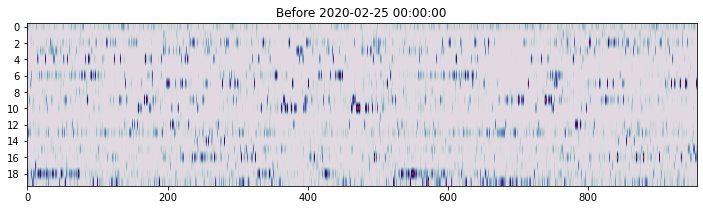

In [34]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(12, 3))
ax.imshow(topics_before.T, cmap='twilight', aspect='auto')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(f'Before {split_date}')
plt.show()

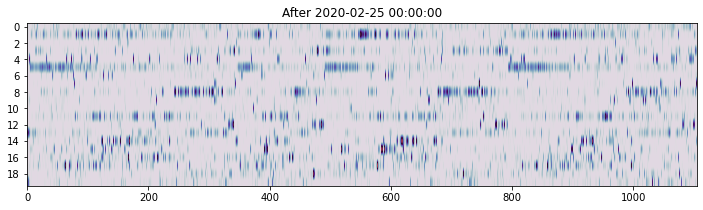

In [35]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.imshow(topics_after.T, cmap='twilight', aspect='auto')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(f'After {split_date}')
plt.show()

### Topic Frequency

x-axis: **토픽 번호 - 1** (i.e. 1번 토픽은 0, 2번토픽은 1 위치에 있음)

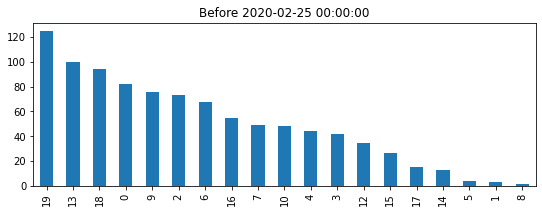

In [36]:
pd.Series(np.argmax(topics_before, axis=1)).value_counts().plot(kind='bar', figsize=(9, 3), title=f'Before {split_date}')
plt.show()

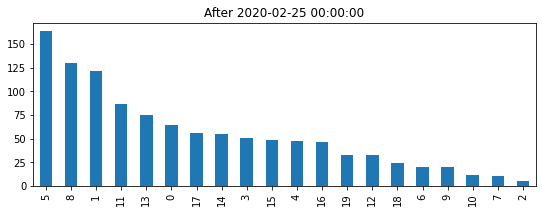

In [38]:
pd.Series(np.argmax(topics_after, axis=1)).value_counts().plot(kind='bar', figsize=(9, 3), title=f'After {split_date}')
plt.show()